## Helper Functions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import h, c, e
import os
from PIL import Image
import numpy as np
import pandas as pd

# Example usage:
# Assuming phase space data is loaded into 'phase_space_data' and third cosine direction is known as 'third_cosine_direction'

# phase_space_data = ... # Load phase space data
# third_cosine_direction = ... # 0 or 1 indicating if pz is positive or negative

# Correct angular dependence
# corrected_weights = correct_angular_dependence(phase_space_data, third_cosine_direction)


def process_phsp_file(filename):
    with open(filename, 'r') as file:

        # Initialize lists to store extracted data
        energies = []
        positions = []
        original_positions = []
        direction_cosines = []
        
        for line in file:
            # Split the line into columns
            columns = line.split()  # Assuming space-separated values

            # Check if the line corresponds to a photon
            if columns[7] == '-22':  
                energy = float(columns[5])  # Energy in MeV
                position = (float(columns[0]), float(columns[1]), float(columns[2]))  # Positions X, Y, Z
                original_position = (float(columns[13]), float(columns[14]), float(columns[15]))  # Positions X, Y, Z
                direction_cosine = (float(columns[3]), float(columns[4]), float(columns[8]))  # Direction cosines X, Y, Z
                energies.append(energy)
                positions.append(position)
                original_positions.append(original_position)
                direction_cosines.append(direction_cosine)

    # Here you can process the extracted data further or save it, etc.
    return energies, positions, direction_cosines, original_positions


def Mev_to_wavelength(energy_Mev):
    # Convert energy from eV to wavelength in meters
    energy_joules = 10**6 * energy_Mev * e
    wavelength_m = h * c / energy_joules
    return wavelength_m

def create_histogram(data, bins):
    # Accumulate the photons in a 2D histogram
    # Assuming data contains x, y positions
    histogram, _, _ = np.histogram2d(data[:,1], data[:,2], bins=bins)
    return histogram

def simulate_camera(histogram, intrinsic_params, extrinsic_params):
    # Simulate the virtual camera recording the photons
    # This is a placeholder function; you need to implement the camera model
    # using the intrinsic and extrinsic parameters provided
    # This function should project the 2D histogram onto the camera sensor
    camera_image = np.zeros_like(histogram)  # Placeholder for the camera image
    return camera_image

# Function to load saved images
def load_images(image_folder):
    images = []
    for filename in os.listdir(image_folder):
        if filename.endswith(".tif"):
            image_path = os.path.join(image_folder, filename)
            image = Image.open(image_path)
            
            # Extracting mus and mua from filename
            mus_mua = filename.split("_mus_")[-1].split("_mua_")
            mus = mus_mua[0]
            mua = mus_mua[1].split(".tif")[0]
            images.append((mus, mua, np.array(image)))
    return images

def correct_angular_dependence(px,py,flag):
    """
    Corrects angular dependence in phase space data.
    
    Parameters:
        phase_space_data (numpy.ndarray): Phase space data array with shape (N, 6),
            where N is the number of particles and 6 represents (x, y, z, px, py, pz).
        third_cosine_direction (int): Third cosine direction indicating if pz is positive (1) or negative (0).
    
    Returns:
        numpy.ndarray: Corrected weights based on angle of incidence.
    """

    if(flag): 
        # Photon is traveling inwards of the z direction
        # pz_sign = -1 
        pz_sign = 0 # Do not use it
    else:
        # Photon is traveling outwards of the z direction
        pz_sign = 1


    # Calculate pz
    pz = pz_sign * np.sqrt(1 - px**2 - py**2)

    polar_angle = np.arccos(pz / np.sqrt(px**2 + py**2 + pz**2))
    polar_angle_degrees = np.degrees(polar_angle)
    cosine_polar_angle = np.cos(np.radians(polar_angle_degrees))

    weights = cosine_polar_angle

    return weights, polar_angle_degrees

## Read in the PHSP file and write it as a CSV

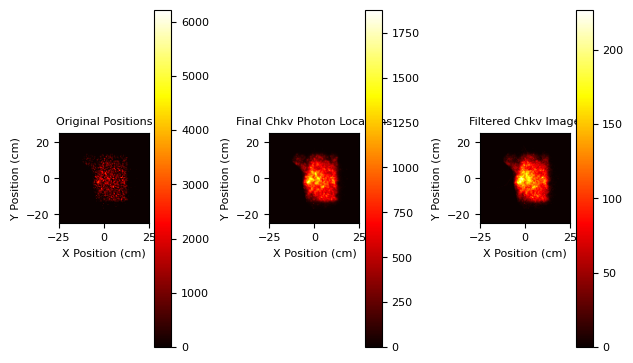

<Figure size 640x480 with 0 Axes>

In [26]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d


# Define the directory containing the files
directory = "/Applications/topas/Annie_BKB/Output"

# Initialize a list to store filenames
filenames = []


# Look up the quantum efficiency for each wavelength
gen3 = pd.read_csv('gen3.csv', header=None,  names=['wavelength','QE'])

    # Create the interpolation function
interpolated_function = interp1d(gen3['wavelength'], gen3['QE'] / max(gen3['QE']), kind='linear')


# Main workflow
for item in os.listdir(directory):
    if item.startswith("phasespace_mybox") and item.endswith(".phsp"):
        filenames.append(item)

# Loop through each filename
for filename in filenames:
    phantomname = filename.split(".")[0]

    fullfilename = os.path.join(directory, filename)

    # Get out energies, positions, and direction_cosigns
    energies, positions, direction_cosines, original_positions = process_phsp_file(fullfilename)

    # Convert energy to wavelength
    wavelengths = 10**9 * np.array([Mev_to_wavelength(energy) for energy in energies])

    # Convert direction cosines to angular correction
    temp = [correct_angular_dependence(direction_cosines[row][0], direction_cosines[row][1], direction_cosines[row][2]) for row in range(len(direction_cosines))]
    angular_weights = [item[0] for item in temp]
    polar_angle_degrees = [item[1] for item in temp]

    # Filter energies and positions based on wavelengths between 400 and 800 nm
    filtered_indices = np.where((wavelengths >= 414) & (wavelengths <= 794))[0]
    filtered_directions = []
    filtered_energies = []
    filtered_wavelengths = []
    filtered_positions = []
    filtered_original_positions = []
    filtered_angular_weights = []
    filtered_qe_weights = []

    # Fileter the energies and weights
    for f in filtered_indices.tolist():
        filtered_energies.append(energies[f]) 
        filtered_wavelengths.append(wavelengths[f]) 
        filtered_positions.append(positions[f])
        filtered_original_positions.append(original_positions[f])
        filtered_angular_weights.append(angular_weights[f])
        filtered_directions.append(direction_cosines[f])
        filtered_qe_weights.append(interpolated_function(wavelengths[f]))

   

    bins = 100

    regular_original_histogram, xedges, yedges = np.histogram2d(
        [row[0] for row in filtered_original_positions],  # x positions
        [row[1] for row in filtered_original_positions],  # y positions
        range=[(-25, 25), (-25, 25)],
        bins=[bins, bins],  # specifying the bin size for both dimensions
    )
    # Calculate the histogram for starting positions
    plt.subplot(1,3,1)
    plt.imshow(regular_original_histogram.T, origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], cmap='hot')
    cbar = plt.colorbar()
    cbar.ax.tick_params(labelsize=8)  # Set color bar tick labels font size

    plt.title("Original Positions", fontsize=8)  # Set title font size
    plt.xlabel("X Position (cm)", fontsize=8)  # Set x-label font size
    plt.ylabel("Y Position (cm)", fontsize=8)  # Set y-label font size
    plt.xticks(fontsize=8)  # Set x-tick font size
    plt.yticks(fontsize=8)  # Set y-tick font size
   

    regular_histogram, xedges, yedges = np.histogram2d(
        [row[0] for row in filtered_positions],  # x positions
        [row[1] for row in filtered_positions],  # y positions
        range=[(-25, 25), (-25, 25)],
        bins=[bins, bins],  # specifying the bin size for both dimensions
    )

    # Calculate the histogram for final positions
    plt.subplot(1,3,2)
    plt.imshow(regular_histogram.T, origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], cmap='hot')

    cbar = plt.colorbar()
    cbar.ax.tick_params(labelsize=8)  # Set color bar tick labels font size

    plt.title("Final Chkv Photon Locations", fontsize=8)  # Set title font size
    plt.xlabel("X Position (cm)", fontsize=8)  # Set x-label font size
    plt.ylabel("Y Position (cm)", fontsize=8)  # Set y-label font size
    plt.xticks(fontsize=8)  # Set x-tick font size
    plt.yticks(fontsize=8)  # Set y-tick font size

    # Calculate the histogram for filtered positions
    filtered_histogram, xedges, yedges = np.histogram2d(
        [row[0] for row in filtered_positions],  # x positions
        [row[1] for row in filtered_positions],  # y positions
        bins=[bins, bins],  # specifying the bin size for both dimensions
        range=[(-25, 25), (-25, 25)],
        weights=np.array(filtered_angular_weights) * np.array(filtered_qe_weights)  # applying angular and QE weights
    )

    plt.subplot(1,3,3)
    plt.imshow(filtered_histogram.T, origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], cmap='hot')
    cbar = plt.colorbar()
    cbar.ax.tick_params(labelsize=8)  # Set color bar tick labels font size

    plt.title("Filtered Chkv Image", fontsize=8)  # Set title font size
    plt.xlabel("X Position (cm)", fontsize=8)  # Set x-label font size
    plt.ylabel("Y Position (cm)", fontsize=8)  # Set y-label font size
    plt.xticks(fontsize=8)  # Set x-tick font size
    plt.yticks(fontsize=8)  # Set y-tick font size
    plt.tight_layout()  # Adjust layout to prevent overlapping
    plt.show()
    plt.savefig("/Applications/topas/Annie_BKB/OutputCherenkovImages/Cherenkov_zprojections.tif")

    # Uncomment the following lines if you want to save the images
    # Convert the numpy array to a PIL image
    image = Image.fromarray(np.uint16(regular_histogram))
    output_path = os.path.join("/Applications/topas/Annie_BKB/OutputCherenkovImages/",
                               'Cherenkov_final_positiions.tif')
    image.save(output_path)

    # Uncomment the following lines if you want to save the images
    # Convert the numpy array to a PIL image
    image = Image.fromarray(np.uint16(regular_original_histogram))
    output_path = os.path.join("/Applications/topas/Annie_BKB/OutputCherenkovImages/",
                               'Cherenkov_original_positiions.tif')
    image.save(output_path)


    # Uncomment the following lines if you want to save the images
    # Convert the numpy array to a PIL image
    image = Image.fromarray(np.uint16(regular_original_histogram))
    output_path = os.path.join("/Applications/topas/Annie_BKB/OutputCherenkovImages/",
                               'Cherenkov_filtered_final_positiions.tif')
    image.save(output_path)


# Write out phase space data as csv

In [24]:
import csv

# Define the filename for the CSV file
csv_filename = "filtered_data.csv"

# Combine the data into a list of lists
data = zip(filtered_energies, filtered_wavelengths, filtered_positions, 
           filtered_original_positions, filtered_angular_weights, 
           filtered_directions, filtered_qe_weights)

# Write the data to the CSV file
with open(csv_filename, "w", newline="") as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(["Energy", "Wavelength", "Position", "Original_Position", 
                     "Angular_Weight", "Direction_Cosines", "QE_Weight"])
    writer.writerows(data)

print("CSV file '{}' has been created successfully.".format(csv_filename))

CSV file 'filtered_data.csv' has been created successfully.


# NOW write the 3D Histograms as DICOMS

In [21]:
import numpy as np
import pydicom
from pydicom.dataset import Dataset, FileDataset
import os
import numpy as np
from stl import mesh
import pydicom
from pydicom.dataset import Dataset, FileDataset
from scipy.ndimage import binary_fill_holes
from skimage.draw import polygon
from scipy import ndimage as ndi


def create_dicom_volume(volume, output_file):
    ds = Dataset()    
    ds.is_little_endian = True
    ds.is_implicit_VR = True
    ds.Modality = "OT"
    ds.StudyInstanceUID = pydicom.uid.generate_uid()
    ds.SeriesInstanceUID = pydicom.uid.generate_uid()
    ds.SOPInstanceUID = pydicom.uid.generate_uid()
    ds.ImagePositionPatient = [-25, -25, -25]  # Assuming start position at origin
    ds.Rows, ds.Columns, ds.NumberOfFrames = volume.shape
    print(volume.shape)
    ds.SamplesPerPixel = 1
    ds.PhotometricInterpretation = "MONOCHROME2"
    ds.PixelRepresentation = 0
    ds.BitsAllocated = 16
    ds.BitsStored = 16
    ds.HighBit = 15
    ds.PixelData = volume.tobytes()
    ds.save_as(output_file)


# Example usage
# Specify the number of bins for each dimension
bins = [100, 100, 100]


# Initial Cherenkov Positions
original_histogram_3d, edges = np.histogramdd(
    np.array(filtered_original_positions),  # list of [x, y, z] coordinates
    range=[(-25, 25), (-25, 25),(-25, 25)],
    bins=bins  # specifying the bin size for all three dimensions
)
output_file = "/Applications/topas/Annie_BKB/Output/Cherenkov_initial_volume.dcm"
create_dicom_volume(original_histogram_3d.astype(np.uint16), output_file)

# Final Cherenkov Positions
regular_histogram_3d, edges = np.histogramdd(
    np.array(filtered_positions),  # list of [x, y, z] coordinates
    range=[(-25, 25), (-25, 25),(-25, 25)],
    bins=bins  # specifying the bin size for all three dimensions
)
output_file = "/Applications/topas/Annie_BKB/Output/Cherenkov_final_volume.dcm"
create_dicom_volume(regular_histogram_3d.astype(np.uint16), output_file)

# Final Filtered Cherenkov Positions
regular_filtered_histogram_3d, edges = np.histogramdd(
    np.array(filtered_positions),  # list of [x, y, z] coordinates
    range=[(-25, 25), (-25, 25),(-25, 25)],
    bins=bins,  # specifying the bin size for all three dimensions
    weights=np.array(filtered_angular_weights) * np.array(filtered_qe_weights)
)
output_file = "/Applications/topas/Annie_BKB/Output/Cherenkov_final_filtered_volume.dcm"
create_dicom_volume(regular_histogram_3d.astype(np.uint16), output_file)



(100, 100, 100)
(100, 100, 100)
(100, 100, 100)


# Sample the surface Cherenkov using the stl volume

(100, 100, 100)


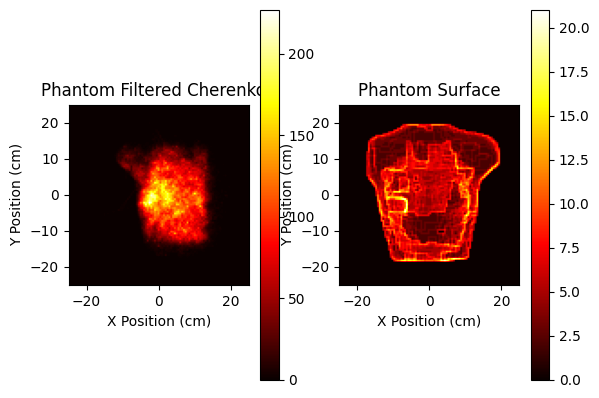

In [22]:
import numpy as np
from stl import mesh
import pydicom
from pydicom.dataset import Dataset, FileDataset
from scipy.ndimage import binary_fill_holes
from skimage.draw import polygon
from scipy import ndimage as ndi
import numpy as np
from scipy.ndimage import binary_erosion
import matplotlib.pyplot as plt

# Function to read STL file and apply rotation and translation
def read_and_transform_stl(file_path, rotation_degrees, translation_cm):
    # Read STL file
    stl_mesh = mesh.Mesh.from_file(file_path)

    # Apply rotation
    stl_mesh.rotate([1, 0, 0], np.radians(rotation_degrees[0]))
    stl_mesh.rotate([0, 1, 0], np.radians(rotation_degrees[1]))
    stl_mesh.rotate([0, 0, 1], np.radians(rotation_degrees[2]))
    
    # Apply translation
    stl_mesh.x += translation_cm[0]
    stl_mesh.y += translation_cm[1]
    stl_mesh.z += translation_cm[2]
    
    return stl_mesh


# Parameters
stl_file_path = '/Applications/topas/Annie_BKB/Segmentation_decimated.stl'
rotation_degrees = [90, 0.0, 0.0]
translation_cm = [0, 0, 0]

voxel_size_cm = 0.1
volume_shape = (100, 100, 100)
output_dicom_file = '/Applications/topas/Annie_BKB/Output/patient_surface_segmentation.dcm'

# Read and transform STL
stl_mesh = read_and_transform_stl(stl_file_path, rotation_degrees, translation_cm)

bins = [100, 100, 100]

# Create a 3D histogram using np.histogramdd
surface_histogram_3d, edges_3d = np.histogramdd(
    np.array(stl_mesh.vectors[:,0]*voxel_size_cm),  
    range=[(-25, 25), (-25, 25), (-25, 25)],
    bins=bins  # specifying the bin size for all three dimensions
)

xedges_stl, yedges_stl, zedges_stl = edges_3d

# Apply median filter to fill holes in the volume
surface_histogram_3d_filled = ndi.maximum_filter(surface_histogram_3d, size=(5, 5, 5))
surface_histogram_3d_filled_filled = ndi.binary_fill_holes(surface_histogram_3d_filled)

# Assuming surface_histogram_3d_filled_filled is your 3D volume
# Define a structuring element for the erosion
structuring_element = np.ones((3, 3, 3))

# Perform binary erosion
eroded_volume = binary_erosion(surface_histogram_3d_filled_filled, structure=structuring_element)

# Subtract the eroded volume from the original to get the surface
phantom_surface = surface_histogram_3d_filled_filled & ~eroded_volume

# Output file to DICOM
output_file = "/Applications/topas/Annie_BKB/Output/surface_volume.dcm"
create_dicom_volume(phantom_surface.astype(np.uint16), output_file)

# Visualization (summing along the z-axis for 2D visualization)
rot_phantom_surface = np.rot90(phantom_surface[:,:,70],k=3)
summed_surface_image = phantom_surface.sum(axis=2)
rot_summed_surface_image = np.rot90(summed_surface_image,k=3)

plt.subplot(1,2,1)
plt.imshow(filtered_histogram.T, origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], cmap='hot')
plt.colorbar()
plt.title("Phantom Filtered Cherenkov")
plt.xlabel("X Position (cm)")
plt.ylabel("Y Position (cm)")

plt.subplot(1,2,2)
plt.imshow(rot_summed_surface_image, origin='lower', extent=[xedges_stl[0], xedges_stl[-1], yedges_stl[0], yedges_stl[-1]], cmap='hot')
plt.colorbar()
plt.title("Phantom Surface")
plt.xlabel("X Position (cm)")
plt.ylabel("Y Position (cm)")

plt.show()




In [19]:
np.shape(phantom_surface)

(100, 100, 100)

Text(0, 0.5, 'Y Position (cm)')

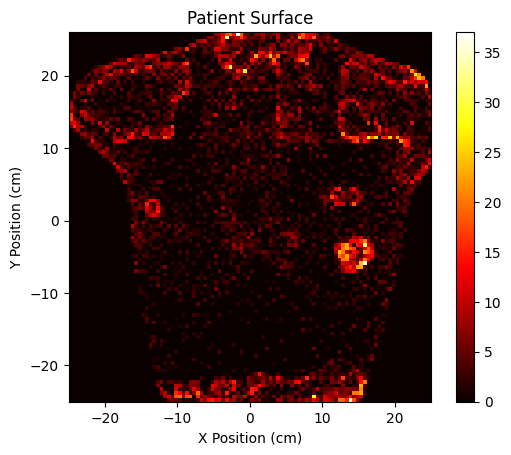

In [ ]:
bins = [100, 100, 100]

# Create a 3D histogram using np.histogramdd
surface_histogram_3d, edges = np.histogramdd(
    np.array(stl_mesh.vectors[:,0]),  # list of [x, y, z] coordinates
    bins=bins  # specifying the bin size for all three dimensions
)


plt.imshow(surface_histogram_3d.T.sum(axis=0), origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], cmap='hot')  # Fixed the extent parameters
plt.colorbar()
plt.title("Patient Surface")  # Removed phantomname as it's not defined in the code snippet
plt.xlabel("X Position (cm)")
plt.ylabel("Y Position (cm)")
